In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)



In [10]:
#Pull data from Measurement 
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
#Pull data from Station
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


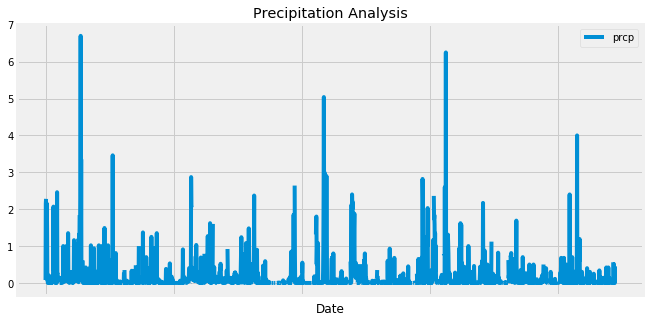

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_data)

# Calculate the date 1 year ago from the last data point in the database
one_yr = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_yr)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > one_yr).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
precip_df = precip_df.set_index('date')
precip_df.head()


# Sort the dataframe by date
precip_sort_df = precip_df.sort_values(by = 'date')
precip_sort_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_sort_df.plot(figsize = (10,5))
ax.set_title("Precipitation Analysis")
ax.set_xlabel("Date")
plt.show()


In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_sort_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {num_stations} stations available in this dataset.")

There are 9 stations available in this dataset.


In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_st = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_st

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_st[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()


[(54.0, 71.66378066378067, 85.0)]

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temp_data = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date >= one_yr).all()

temp_ob = pd.DataFrame(temp_data)
temp_ob.set_index('station', inplace=True)
temp_ob.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


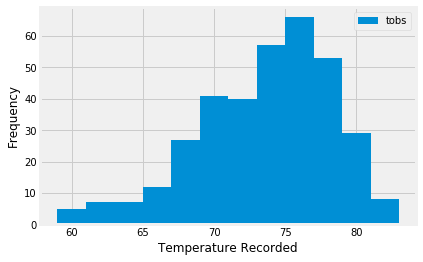

In [37]:
#Plot histogram of results 
plt.hist(temp_ob['tobs'], bins=12)
plt.xlabel("Temperature Recorded")
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()